## This notebook will get model outputs from the Community Firn Model to compare to the Summit data

In [2]:
### Import necessary python packages and CFM code.
# import statsmodels.api as sm
import h5py as h5
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.dates import DateFormatter
import numpy as np
import scipy as sp
import pandas as pd
import netCDF4 as nc
import sys
import os
import pickle
import seaborn as sns 
import glob
# from datetime import datetime, timedelta, date
import time
import json
import shutil
import xarray as xr
import copy
import tables as tb
import datetime
import calendar
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning) # turn off future warning for frame.append
pd.options.mode.chained_assignment = None # turn off chained assignment warning, default = 'warn'

import matplotlib.dates as mdates
years = mdates.YearLocator()   # every year
months = mdates.MonthLocator()  # every month
years_fmt = mdates.DateFormatter('%Y')

from sklearn.metrics import mean_squared_error
import math
np.seterr(invalid='ignore')

SPY = 365.25*24*3600

try:
    sys.path.append('/Users/cdsteve2/research/firn/CommunityFirnModel/CFM_main/')
except:
    pass

from firn_density_nospin import FirnDensityNoSpin
from siteClimate_from_RCM import getClimate #get data from RCM
from RCMpkl_to_spin import makeSpinFiles

In [3]:
# Default Settings for figures
sb=True
if sb:
    sns.set()
    sns.set_context('paper', font_scale=1.5, rc={"lines.linewidth": 1.5})
#     sns.set_context("notebook", font_scale=1.5, rc={"lines.linewidth": 2.5})
    sns.set_style("whitegrid",{"xtick.top":True, "xtick.bottom":True,"ytick.left":True, "ytick.right":True})
# plt.style.use('seaborn-notebook')

# pd.set_option('display.height', 500)
pd.set_option('display.max_rows', 500)
mpl.rcParams['axes.formatter.useoffset'] = False
mpl.rcParams.update({'figure.autolayout': True})
fontsz = 20
plt.rc('xtick',labelsize=20)
plt.rc('ytick',labelsize=20)
plt.rcParams['axes.titlesize'] = 22
plt.rcParams["axes.labelsize"] = 22
plt.rcParams['figure.figsize'] = [10, 8]
palette = sns.color_palette()

In [4]:
def toYearFraction(date):
    '''
    convert datetime to decimal date 
    '''
    def sinceEpoch(date): # returns seconds since epoch
        return calendar.timegm(date.timetuple())
    s = sinceEpoch

    year = date.year
    startOfThisYear = datetime.datetime(year=year, month=1, day=1)
    startOfNextYear = datetime.datetime(year=year+1, month=1, day=1)

    yearElapsed = s(date) - s(startOfThisYear)
    yearDuration = s(startOfNextYear) - s(startOfThisYear)
    fraction = yearElapsed/yearDuration

    return date.year + fraction

def decyeartodatetime(din):
    start = din
    rem, year = np.modf(din)
    base = datetime.datetime(int(year), 1, 1)
    result = base + datetime.timedelta(seconds=(base.replace(year=base.year + 1) - base).total_seconds() * rem)
    result2 = result.replace(second=0, microsecond=0)
    return result2

# Look at the Physics Schemes for Summit Data

### You will need to change this cell to fit the lat/lon values and the filename prefix that you want

In [11]:
lat_int = 72.5 # latitude of interest
lon_int = -38.75 #longitude
# data_source = 'CFM_smetinput'
data_source = 'MERRA2_CLIM_df'

### In general, the lat/lon on the MERRA2 grid will not be the same at the 'int' values you put in - the function above 
### finds the MERRA2 grid point closest to the point you entered, and saves it as 'lat_val' and 'lon_val'
### but for now we can just set them equal, and load the .pkl for that point.

lat_val = lat_int
lon_val = lon_int

summit_df = pd.read_pickle(f'../Summit_compaction.pkl')
compaction_df = pd.read_pickle(f'../compaction_df.pkl')

try:
    df_daily = pd.read_pickle(f'C:/Users/dswan1/Downloads/CFM/CommunityFirnModel/CFM_main/MERRA2_CLIM_df_{lat_val}_{lon_val}.pkl')
except:
    df_daily = pd.read_pickle(f'/Users/cdsteve2/research/firn/CommunityFirnModel/CFM_main/IDS/pickle/MERRA2_CLIM_df_{lat_int}_{lon_int}.pkl')

t_adjust = 1.5
df_daily_adjusted = df_daily.copy()
df_daily_adjusted['TS'] = df_daily_adjusted['TS'] + t_adjust

In [10]:
# summit_df.head()

In [11]:
# compaction_df.head()

In [12]:
R          = 8.314                          # gas constant used to calculate Arrhenius's term
S_PER_YEAR = 31557600.0                     # number of seconds in a year
spy = S_PER_YEAR
RHO_1      = 550.0                          # cut off density for the first zone densification (kg/m^3)
RHO_2      = 815.0                          # cut off density for the second zone densification (kg/m^3)
RHO_I      = 917.0                          # density of ice (kg/m^3)
RHO_I_MGM  = 0.917                          # density of ice (g/m^3)
RHO_1_MGM  = 0.550                          # cut off density for the first zone densification (g/m^3)
GRAVITY    = 9.8                            # acceleration due to gravity on Earth
K_TO_C     = 273.15                         # conversion from Kelvin to Celsius
BDOT_TO_A  = S_PER_YEAR * RHO_I_MGM         # conversion for accumulation rate
RHO_W_KGM  = 1000.                          # density of water
P_0 = 1.01325e5

In [13]:
# Load the model outputs
fns = ['KuipersMunneke2015','GSFC2020']
# fns = ['HLdynamic', 'Li2011']
# fns = ['Morris2014', 'Crocus']
rvs = [315,350]
rd = {} #results dictionary
for physics in fns:
    for rv in rvs:
        print(physics)
        print(rv)
        ff = f'CFMoutputs/CFMresults_{lat_val}_{lon_val}_{physics}_{rv}_Tplus{t_adjust}/CFMresults.hdf5'
        open_fn = h5.File(ff,'r') # Open the CFM results file
        physics_rv = physics + '_' + str(rv)
        print(physics_rv)
        vars_list = list(open_fn.keys()) # Make a list of the variables stored in the file
        # The first row in each of the model outputs is the initial condition, so we don't want that (i.e. start by using the data in 2nd row)
        # The first column is the time step. So, we use index [1:,1:] on most of the variables to get just the data we want.
        rd[physics_rv] = {}
        rd[physics_rv]['model_time'] = open_fn['density'][1:,0]
        rd[physics_rv]['depth'] = open_fn['depth'][1:,1:] # Put the depth data into a numpy array
        rd[physics_rv]['density'] = open_fn['density'][1:,1:] # Put the density data into an array
        rd[physics_rv]['temperature'] = open_fn['temperature'][1:,1:]
        rd[physics_rv]['DIP'] = open_fn['DIP'][1:,1:]
        rd[physics_rv]['Dcon'] = open_fn['Dcon'][1:,1:]
        open_fn.close() # Close the file

KuipersMunneke2015
315
KuipersMunneke2015_315
KuipersMunneke2015
350
KuipersMunneke2015_350
GSFC2020
315
GSFC2020_315
GSFC2020
350
GSFC2020_350


In [14]:
SumIds = compaction_df[compaction_df.sitename=='Summit'].index.get_level_values(0).unique()

In [15]:
# SumIds

In [16]:
idict = {}
for II in SumIds:
    DFI = compaction_df.loc[II]
    DFI['ccomp'] = DFI['compaction_borehole_length_m'].iloc[0] - DFI['compaction_borehole_length_m'] #ccomp = cummualtive compaction
    dt = (DFI.index[1] - DFI.index[0]).total_seconds()
    deltaL = -1*DFI['compaction_borehole_length_m'].diff()
    deltaL[deltaL>0.002] = np.nan
    DFI['deltaL'] = deltaL
    DFI['comp_rate_yr'] = DFI['deltaL']/dt*S_PER_YEAR
    idict[II] = DFI

In [17]:
# ## Plot Compaction Rates for all instruments
# for II in SumIds:
#     f1,a1 = plt.subplots(figsize=(8,5))
#     d2 = idict[II]
#     d2['comp_rate_yr'].plot(ax=a1)
#     a1.set_title(f'Compaction Rate Instrument {II}')

Text(0.5, 1.0, 'Compaction Rate Instrument 30')

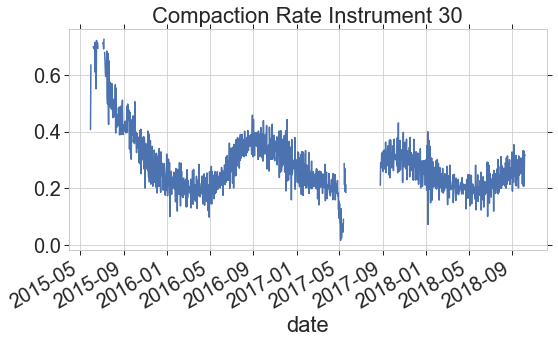

In [18]:
## Plot Compaction Rate for just Instrument 30
II = 30
f1,a1 = plt.subplots(figsize=(8,5))
d2 = idict[II]
d2['comp_rate_yr'].plot(ax=a1)
a1.set_title(f'Compaction Rate Instrument {II}')

# for physics_rv in rd.keys():
# within loop call getmodeledcompaction function
# a1.plot(compaction_modeled.index,compaction_modeled['comp_rate'],label=physics_rv)

In [19]:
# for II in SumIds:
#     f1,a1 = plt.subplots(figsize=(8,5))
#     compaction_modeled = idict[II]
#     compaction_modeled['comp_rate'].plot(ax=a1)
#     a1.set_title(f'Compaction Rate Instrument {II}')

In [20]:
'''
use this to calculate compaction rates
st refers to start, i.e. first day of the experiment
top refers to the location of the upper part of the firn compaction instrument, which at summit was installed on the surface (0m depth)
bottom (or bot) refers to the location of the bottom of the borehole/compaction instrument
i at the beginning of a variable indicates it is an index
Dcon is the layer identification number
'''
S_PER_YEAR = 31557600.0

def getModeledCompaction(time_st,time_end,initial_top,initial_bot,model_run):

    # time_st = 2015.4
    # time_end = 2018.3
    # initial_top = 0
    # initial_bot = 15.73

    i_time_st = np.where(rd[model_run]['model_time']>=time_st)[0][0] #index of the first time step in the experiment (i.e. what row # to choose to get model results for that time step)
    i_time_end = np.where(rd[model_run]['model_time']<time_end)[0][-1] #index of the last time step in the experiment
    experiment_time = rd[model_run]['model_time'][i_time_st:i_time_end+1] # +1 because python indexing is exclusive of last value 
    experiment_datetime = [decyeartodatetime(kk) for kk in experiment_time] # convemodel_run the model time (decimal date format) to a python date.

    depths_st = rd[model_run]['depth'][i_time_st,:] #vector of model node depths at i_time_st

    i_top_st = np.where(depths_st>=initial_top)[0][0] #index at top, at stamodel_run of experiment
    i_bot_st = np.where(depths_st>=initial_bot)[0][0] #index where the bottom is, at stamodel_run of experiment

    dc_top = rd[model_run]['Dcon'][i_time_st,i_top_st] # Dcon value of top
    dc_bot = rd[model_run]['Dcon'][i_time_st,i_bot_st] # Dcon value of bottom
    ### (we will track the positions of these layers through time using Dcon)

    ### initialize vectors to fill in loop
    depths_top = np.zeros_like(experiment_time)
    depths_bot = np.zeros_like(experiment_time)

    ### loop through each time step in the model that overlaps with the time of the experiment
    for jj, et in enumerate(experiment_time): #jj is the loop indexer (i.e. 0,1,2...) and et is the value of experiment_time at jj
        i_mt = np.where(rd[model_run]['model_time']==et)[0][0] #index of where the model time equals experiement time
        i_dc_top = np.where(rd[model_run]['Dcon'][i_mt,:]==dc_top)[0][0] #index of the dc_top node at time et
        i_dc_bot = np.where(rd[model_run]['Dcon'][i_mt,:]==dc_bot)[0][0] #index of the dc_bot node at time et
        depths_top[jj] = rd[model_run]['depth'][i_mt,i_dc_top] #depth of top at time et
        depths_bot[jj] = rd[model_run]['depth'][i_mt,i_dc_bot] #depth of bot at time et

    ### Create a pandas dataframe and add some more columns to get quantity we are interested in
    compaction_modeled = pd.DataFrame({'depths_top':depths_top, 'depths_bot': depths_bot},index=experiment_datetime)
    compaction_modeled['borehole_length'] = depths_bot - depths_top
    compaction_modeled['deltaL'] = -1*compaction_modeled['borehole_length'].diff()
    deltat = compaction_modeled.index.to_series().diff().mean().total_seconds() #average time, in seconds between model steps (5 days)
    compaction_modeled['comp_rate'] = compaction_modeled['deltaL']/deltat*S_PER_YEAR

    return compaction_modeled

In [21]:
### calculate compaction rates from each model run, put them in a dataframe, and put each of those dataframes into a dictionary for storage
# Summit_data = pd.read_pickle('/Users/cdsteve2/research/firn/firncover/Summit_compaction.pkl')
i30d = summit_df.loc[30]
st_top = 0
st_bot = i30d.hole_init_length[0]
stdf = toYearFraction(i30d.index[0])
endf = toYearFraction(i30d.index[-1]) #index [-1] indicating the end

modeled_comp_dict = {}

for model_name in rd.keys():
    modeled_comp_dict[model_name]=getModeledCompaction(stdf,endf,st_top,st_bot,model_name)
    # print(modeled_comp_dict[model_name])

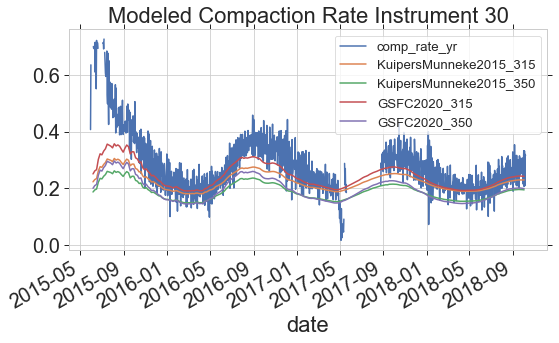

In [22]:
### plotting just instrument 30
# make the plot, plot the actual data 
II = 30
f1,a1 = plt.subplots(figsize=(8,5))
d2 = idict[II]
d2['comp_rate_yr'].plot(ax=a1)
a1.set_title(f'Modeled Compaction Rate Instrument {II}')

# then a loop like this to get the model results into the plot (grabbing the correct dataframe from modeled_comp_dict)

for model_name in rd.keys():
    comp_dataframe = modeled_comp_dict[model_name]
    a1.plot(comp_dataframe.index,comp_dataframe['comp_rate'],label=model_name)
a1.legend()

figfilename = f'Instrument_{II}_{lat_val}_{lon_val}_Modeled_Comp.png'
f1.savefig(figfilename)

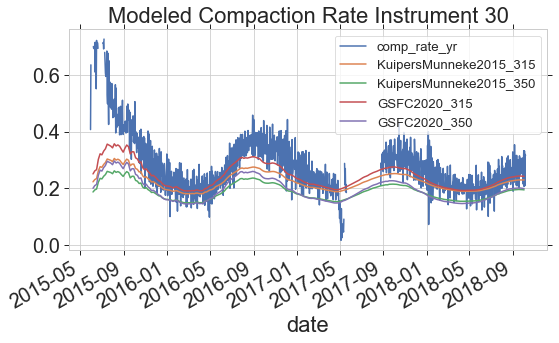

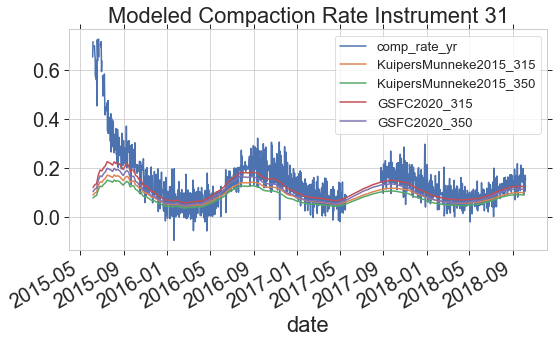

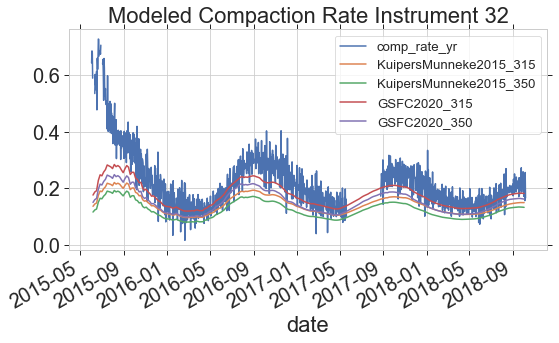

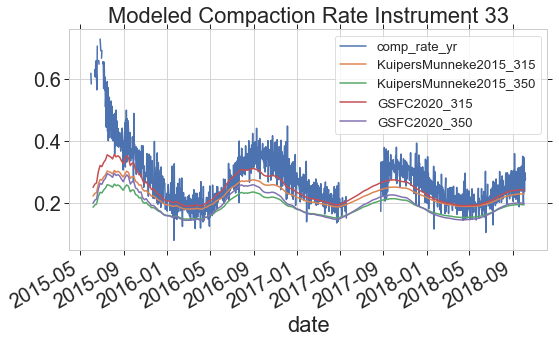

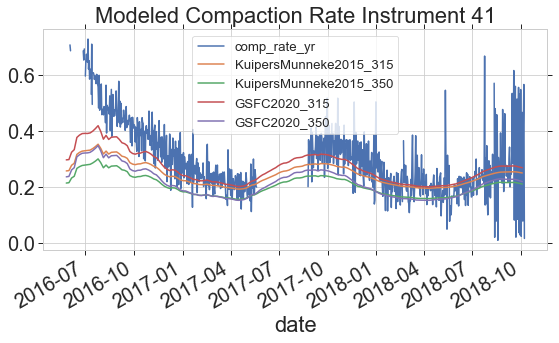

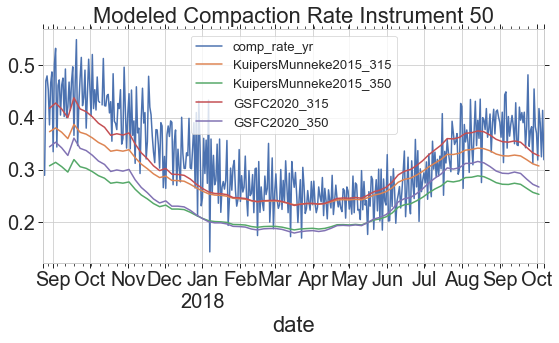

In [23]:
## Loop through all instruments for Summit data 
for II in SumIds:
    f1,a1 = plt.subplots(figsize=(8,5))
    compaction_observed = idict[II]
    compaction_observed['comp_rate_yr'].plot(ax=a1)
    a1.set_title(f'Modeled Compaction Rate Instrument {II}')
    
        ### calculate compaction rates from each model run, put them in a dataframe, and put each of those dataframes into a dictionary for storage
    # Summit_data = pd.read_pickle('/Users/cdsteve2/research/firn/firncover/Summit_compaction.pkl')
    INdf = summit_df.loc[II]
    st_top = 0
    st_bot = INdf.hole_init_length[0]
    stdf = toYearFraction(INdf.index[0])
    endf = toYearFraction(INdf.index[-1]) #index [-1] indicating the end

    modeled_comp_dict = {}

    for model_name in rd.keys():
        modeled_comp_dict[model_name]=getModeledCompaction(stdf,endf,st_top,st_bot,model_name)
        # print(modeled_comp_dict[model_name])
        comp_dataframe = modeled_comp_dict[model_name]
        a1.plot(comp_dataframe.index,comp_dataframe['comp_rate'],label=model_name)
    
    # for model_name in rd.keys():
    #     comp_dataframe = modeled_comp_dict[model_name]
    #     a1.plot(comp_dataframe.index,comp_dataframe['comp_rate'],label=model_name)
    a1.legend()

    figfilename = f'Instrument_{II}_{lat_val}_{lon_val}_Modeled_Comp.png'
    f1.savefig(figfilename)

## FirnCover Summit Core Data

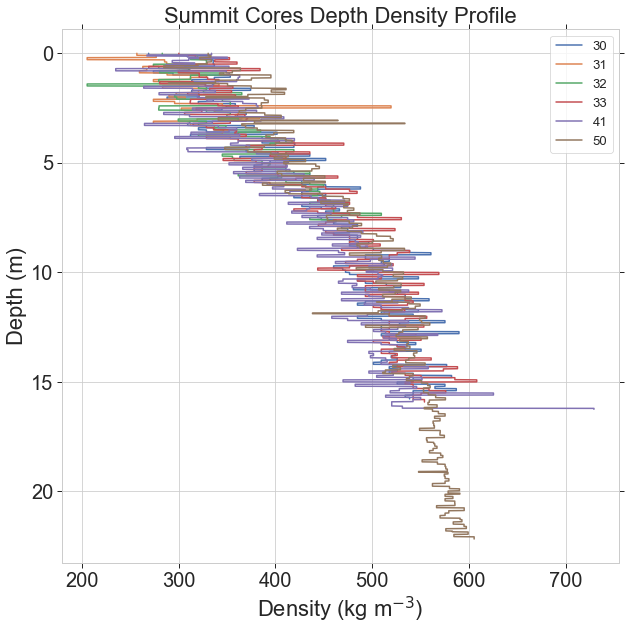

In [24]:
## plot the summit core depth densitry profile 
f1,a1 = plt.subplots(figsize=(9,9))
Summit_cores = pd.read_pickle('FC_SummitCores.pkl')
core_numbers = Summit_cores.index.get_level_values(0).unique() #unique core numbers
### To get data for one of the cores:
xx = Summit_cores.loc[core_numbers[0]]
### or you could put each core's data in its own dataframe, and put those in a dictionary:
core_dict = {}    
for core_num in core_numbers:
    core_to_plot = Summit_cores.loc[core_num]
    # core_dict[core_num]['depth'] = Summit_cores['depth'][1:,1:]
    a1.plot(core_to_plot['density'], core_to_plot['depth'], label = core_num)
    # a1.plot(core_dict['density'],core_dict['depth'],label=core_num)
a1.set_title(f'Summit Cores Depth Density Profile')
a1.set_xlabel('Density (kg m$^{-3}$)')
a1.set_ylabel('Depth (m)')
a1.invert_yaxis()
a1.legend()
figfilename = f'Core_Depth_Density.png'
f1.savefig(figfilename)

In [25]:
# Summit_cores

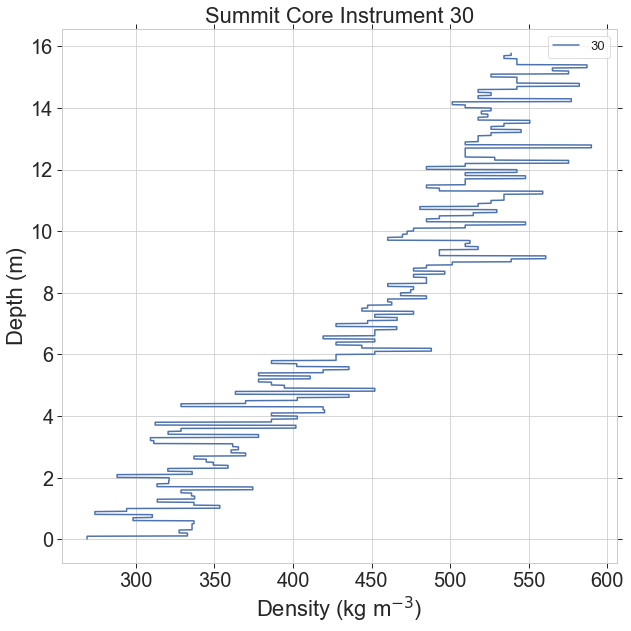

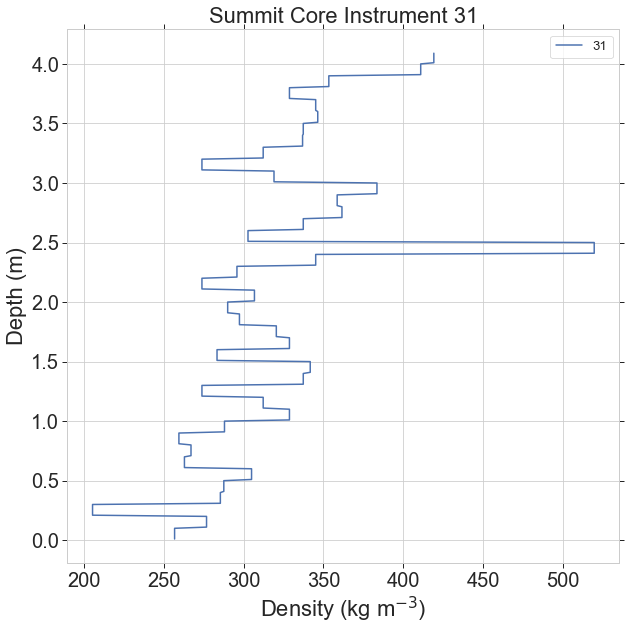

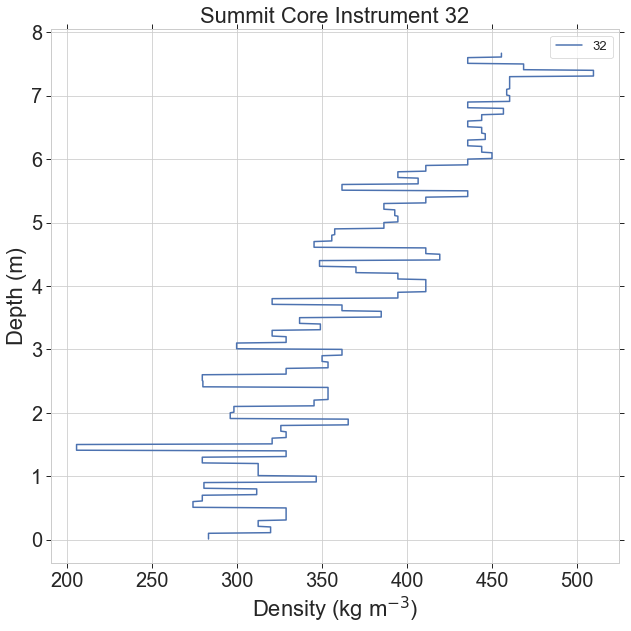

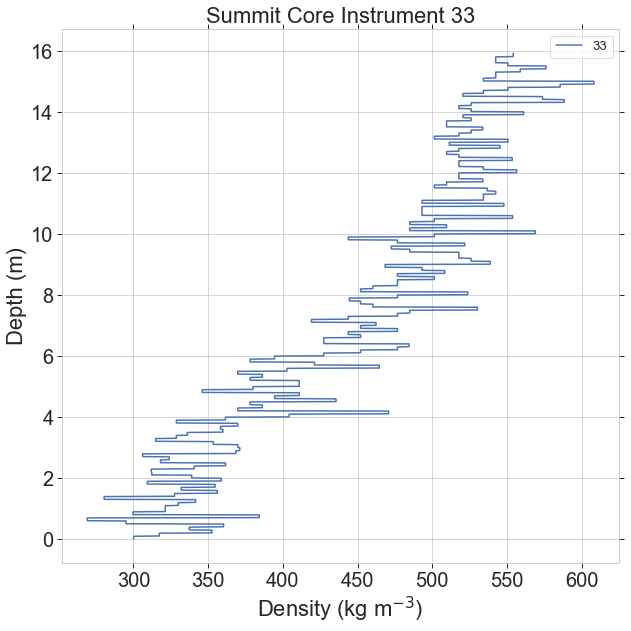

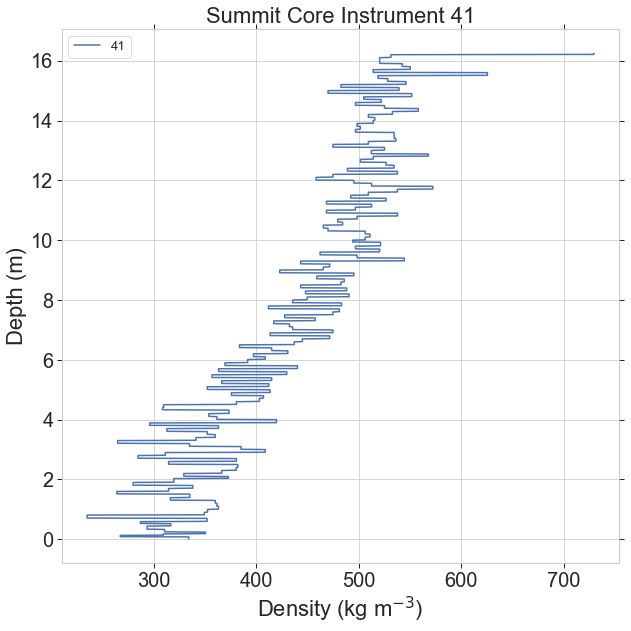

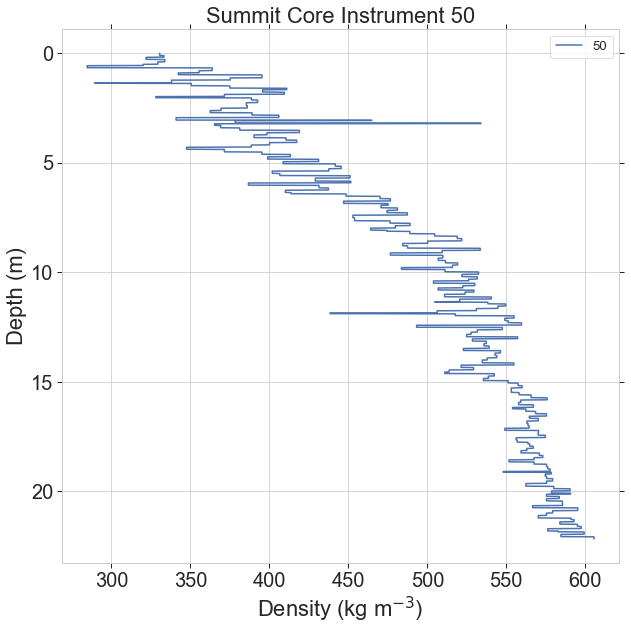

In [26]:
## Plot the summit core depth-density profiles individually 

Summit_cores = pd.read_pickle('FC_SummitCores.pkl')
core_numbers = Summit_cores.index.get_level_values(0).unique() #unique core numbers
core_dict = {}    
for core_num in core_numbers:
    f1,a1 = plt.subplots(figsize=(9,9))
    core_to_plot = Summit_cores.loc[core_num]
    a1.plot(core_to_plot['density'], core_to_plot['depth'], label = core_num)
    a1.set_title(f'Summit Core Instrument {core_num}')
    a1.set_xlabel('Density (kg m$^{-3}$)')
    a1.set_ylabel('Depth (m)')
    a1.legend()
    figfilename = f'Core_{core_num}_Depth_Density.png'
    f1.savefig(figfilename)
a1.invert_yaxis()

In [27]:
# def getModeledCores(time_st,time_end,initial_top,initial_bot,model_run):
def getModeledCores(core_date_dec,model_run):
    
    i_time_st = np.where(rd[model_run]['model_time']>=core_date_dec)[0][0] #index of when model_time equals the core_date (or first model time step after)
    
    model_depth = rd[model_run]['depth'][i_time_st,:] #vector of model node depths at i_time_st
    model_density = rd[model_run]['density'][i_time_st,:] #vector of model node depths at i_time_st
        
    ### Create a pandas dataframe and add some more columns to get quantity we are interested in
    modeled_cores = pd.DataFrame({'depth':model_depth, 'density': model_density})
    
    return modeled_cores

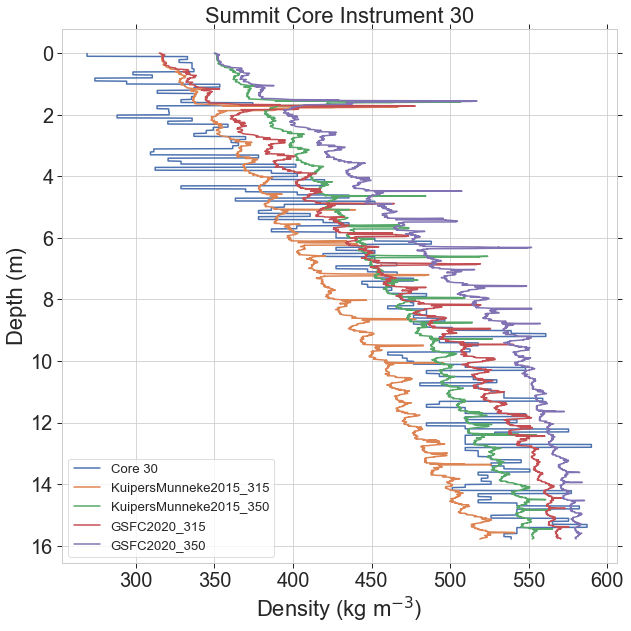

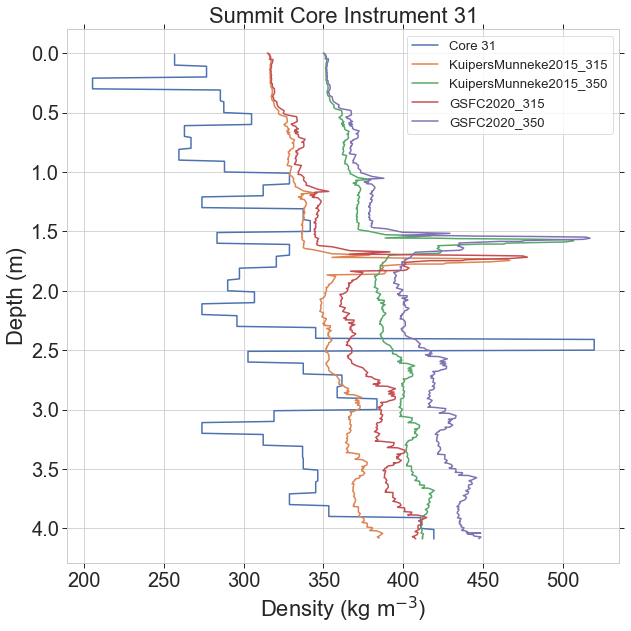

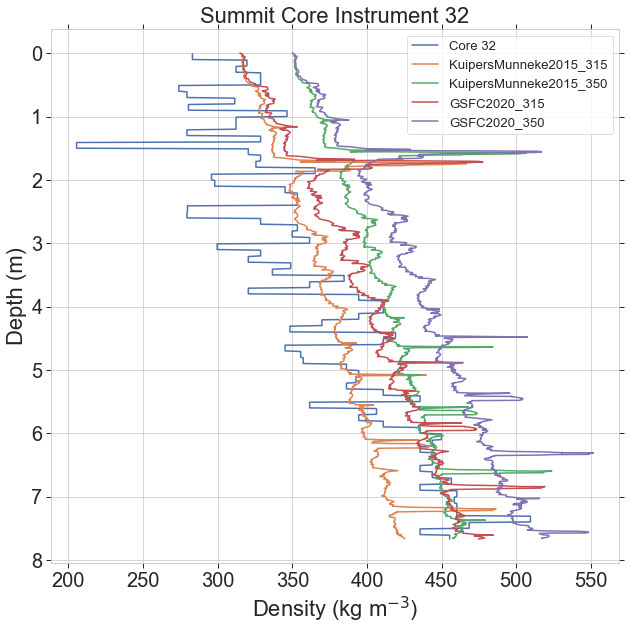

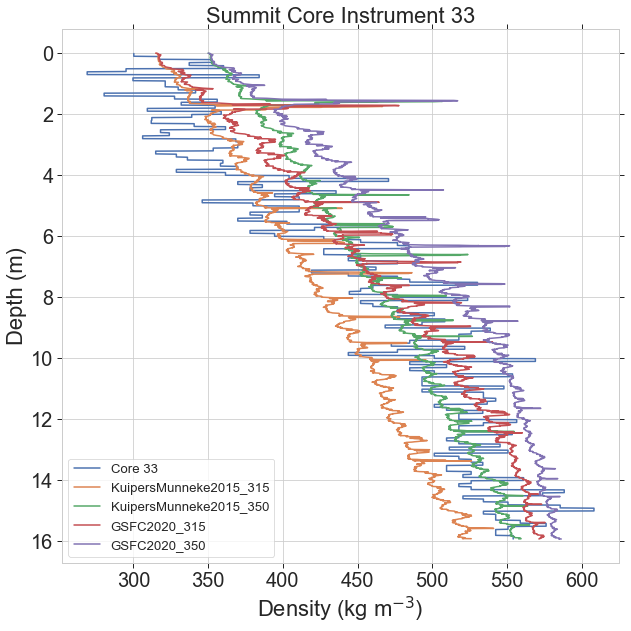

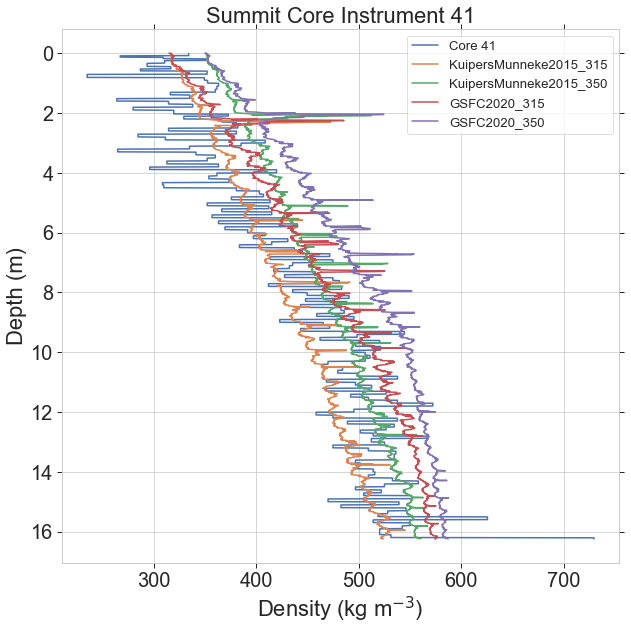

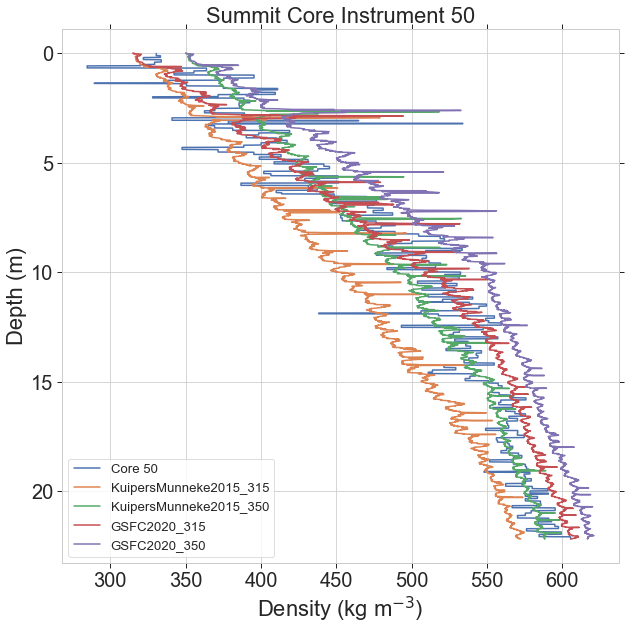

In [28]:
## Loop through all instruments for Summit cores
Summit_cores = pd.read_pickle('FC_SummitCores.pkl')
core_numbers = Summit_cores.index.get_level_values(0).unique() #unique core numbers
core_dict = {}    
for core_num in core_numbers:
    f1,a1 = plt.subplots(figsize=(9,9))
    core_to_plot = Summit_cores.loc[core_num]
    a1.plot(core_to_plot['density'], core_to_plot['depth'], label = f'Core {core_num}')
    a1.set_title(f'Summit Core Instrument {core_num}')
    a1.set_xlabel('Density (kg m$^{-3}$)')
    a1.set_ylabel('Depth (m)')
    # figfilename = f'Core_{core_num}_Depth_Density.png'
    # f1.savefig(figfilename)
    
    core_maximum_depth = core_to_plot.depth.max() #(MS) let's get the maximum depth of the observed core, and we'll use that to only plot the model outputs to that depth.
    
    # core_df = Summit_cores.loc[core_num] #(MS) you don't need this because you already have core_to_plot
    
    core_date = core_to_plot.index[0] #(MS) this is the date that the core was drilled, in YYYY-MM-DD format
    core_date_dec = toYearFraction(core_date) #(MS) this is the date that the core was drilled, in decimal date format, e.g. 2015.405
    
    modeled_cores_dict = {}

    for model_name in rd.keys():
        modeled_cores_dict[model_name]=getModeledCores(core_date_dec,model_name)
        # print(modeled_cores_dict[model_name])
        modeled_cores_dataframe = modeled_cores_dict[model_name] #(MS) this is now a dataframe with the depth and density for a particular model run
        # a1.plot(cores_dataframe[model_name]['density'],cores_dataframe[model_name]['depth'],label=model_name)
        
        modeled_cores_toplot = modeled_cores_dataframe[modeled_cores_dataframe['depth']<core_maximum_depth]
        
        a1.plot( modeled_cores_toplot['density'], modeled_cores_toplot['depth'],label=model_name) #(MS) 'cores_dataframe' is already selecting just the dataframe for a particular model, so we can directly call the columns in that
    
    a1.legend()
    a1.invert_yaxis() #(MS) note that I put this at the same indentation level as f1,a1 = ...
    figfilename = f'Modeled_Core_{core_num}_Depth_Density.png'
    f1.savefig(figfilename)

RMSE Instrument 30, KuipersMunneke2015_315:
0.16980178332153575
RMSE Instrument 30, KuipersMunneke2015_350:
0.29606100608781194
RMSE Instrument 30, GSFC2020_315:
0.1320254309623255
RMSE Instrument 30, GSFC2020_350:
0.2912043444951184
RMSE Instrument 31, KuipersMunneke2015_315:
0.4046872221326721
RMSE Instrument 31, KuipersMunneke2015_350:
0.4961256890007856
RMSE Instrument 31, GSFC2020_315:
0.2671873218937425
RMSE Instrument 31, GSFC2020_350:
0.36828260383885586
RMSE Instrument 32, KuipersMunneke2015_315:
0.5074884036530077
RMSE Instrument 32, KuipersMunneke2015_350:
0.5979954032985632
RMSE Instrument 32, GSFC2020_315:
0.3746151012809373
RMSE Instrument 32, GSFC2020_350:
0.4792885021168031
RMSE Instrument 33, KuipersMunneke2015_315:
0.16060945392289588
RMSE Instrument 33, KuipersMunneke2015_350:
0.28368795565976873
RMSE Instrument 33, GSFC2020_315:
0.12691829815225442
RMSE Instrument 33, GSFC2020_350:
0.28232600077992104
RMSE Instrument 41, KuipersMunneke2015_315:
0.2219904184186718
RM

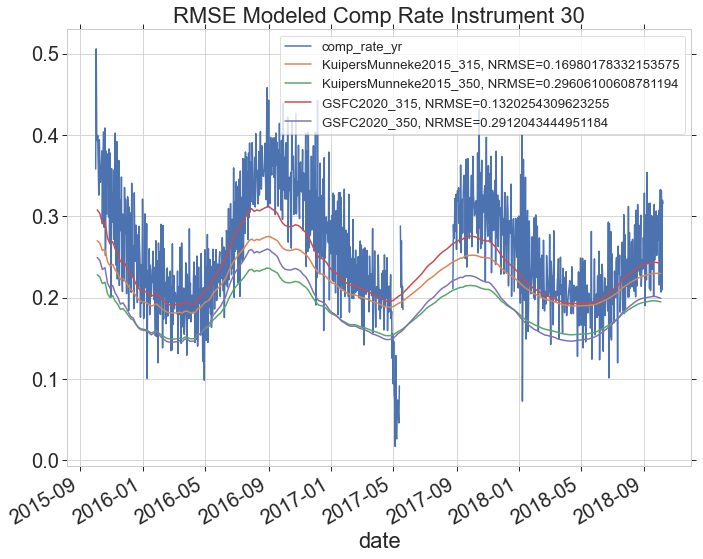

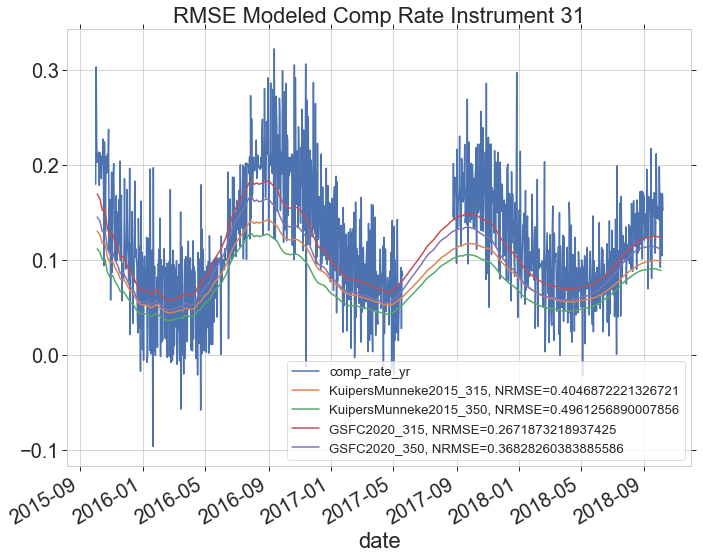

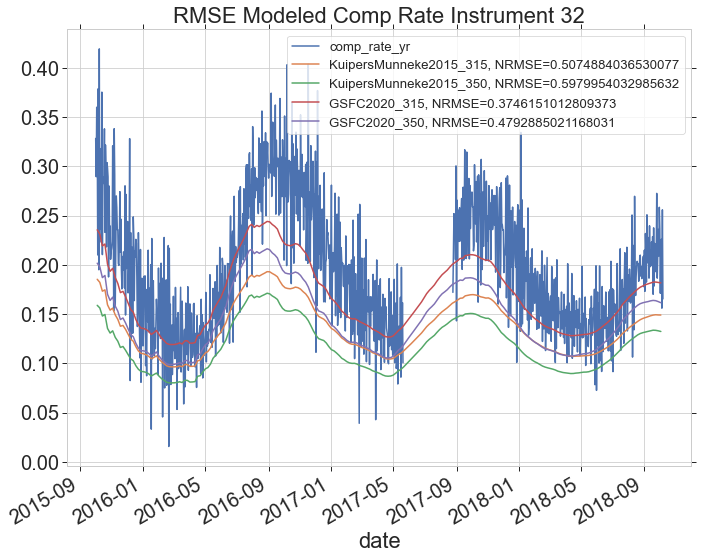

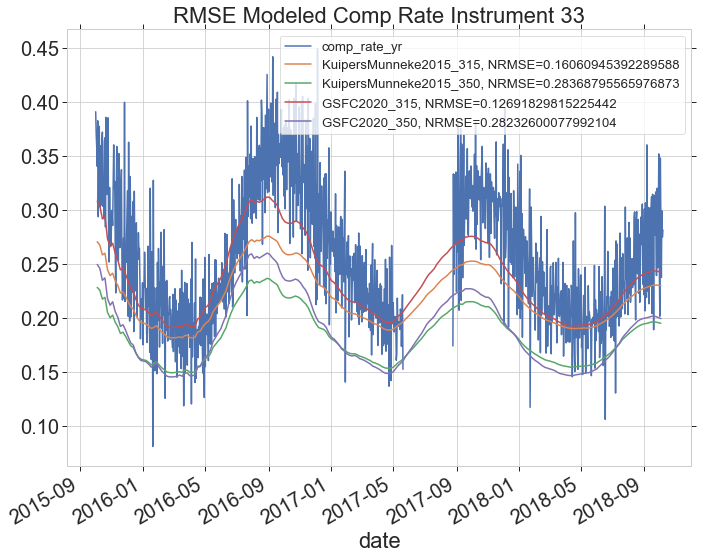

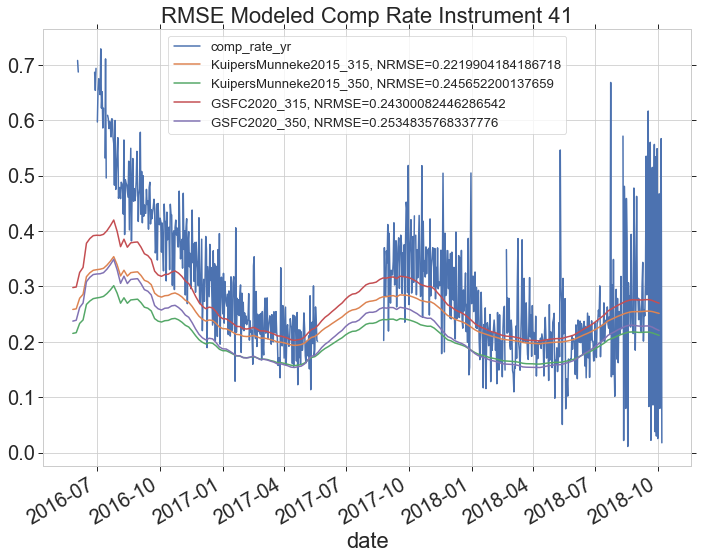

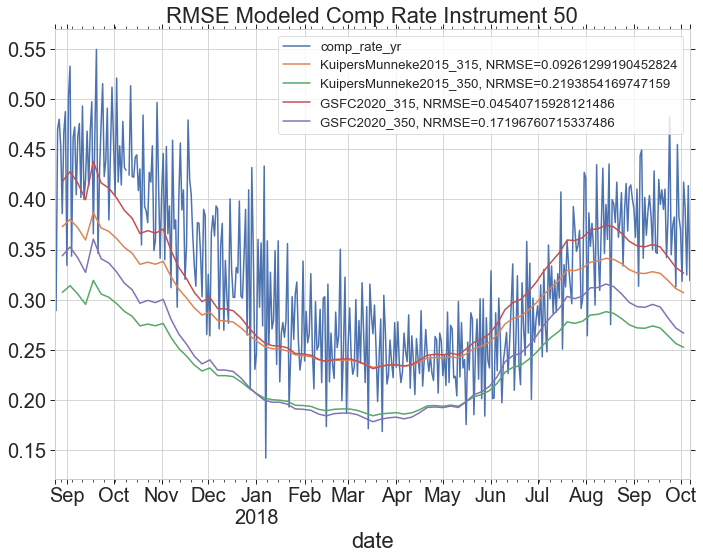

In [29]:
### RMSE
## Loop through all instruments for Summit data 
for II in SumIds:
    f1,a1 = plt.subplots(figsize=(10,8))
    compaction_observed = idict[II]
    y_measured =compaction_observed['comp_rate_yr'].loc['2015-10':]    
    y_measured.plot(ax=a1)
    a1.set_title(f'RMSE Modeled Comp Rate Instrument {II}')
    
        ### calculate compaction rates from each model run, put them in a dataframe, and put each of those dataframes into a dictionary for storage
    # Summit_data = pd.read_pickle('/Users/cdsteve2/research/firn/firncover/Summit_compaction.pkl')
    INdf = summit_df.loc[II]
    st_top = 0
    st_bot = INdf.hole_init_length[0]
    stdf = toYearFraction(INdf.index[0])
    endf = toYearFraction(INdf.index[-1]) #index [-1] indicating the end

    modeled_comp_dict = {}

    for model_name in rd.keys():
        modeled_comp_dict[model_name]=getModeledCompaction(stdf,endf,st_top,st_bot,model_name)
        # print(modeled_comp_dict[model_name])
        comp_dataframe = modeled_comp_dict[model_name].loc['2015-10':]
        # y_modeled = comp_dataframe['comp_rate']
        y_modeled = comp_dataframe['comp_rate']
        MSE = np.square(np.subtract(y_measured,y_modeled)).mean() 
        RMSE = math.sqrt(MSE)
        NRMSE = RMSE/y_measured.mean()
        print(f'RMSE Instrument {II}, {model_name}:')
        print(NRMSE)
        a1.plot(comp_dataframe.index,comp_dataframe['comp_rate'],label = f'{model_name}, NRMSE={NRMSE}')
    a1.legend()
    figfilename = f'NRMSE_{II}_{lat_val}_{lon_val}.png'
    f1.savefig(figfilename)

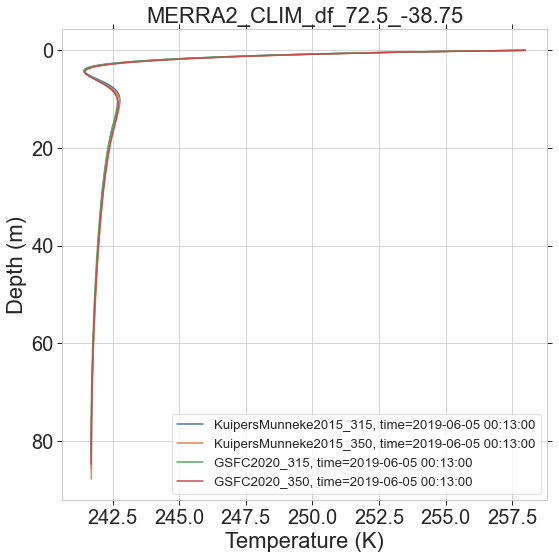

In [30]:
# Plot temperature with depth
f1,a1=plt.subplots(figsize=(8,8))
for physics_rv in rd.keys():
    rd[physics_rv]['Datetime'] = pd.to_datetime([decyeartodatetime(iii) for iii in rd[physics_rv]['model_time']])
    itime = np.where(rd['KuipersMunneke2015_315']['Datetime']>='2019-06')[0][0]
    a1.plot(rd[physics_rv]['temperature'][itime,:],rd[physics_rv]['depth'][itime,:],label=f'{physics_rv}, time={rd[physics_rv]["Datetime"][itime]}')
a1.invert_yaxis()
a1.legend()
a1.set_xlabel('Temperature (K)')
a1.set_ylabel('Depth (m)')
a1.set_title(f'{data_source}_{lat_val}_{lon_val}')

figfilename = f'{data_source}_{lat_val}_{lon_val}_Temp_Depth.png'
f1.savefig(figfilename)

GSFC2020
315
GSFC2020_315


C:\Users\dswan1\AppData\Local\Temp\1\ipykernel_6492\151041594.py:56: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  cb1 = f1.colorbar(cax1)


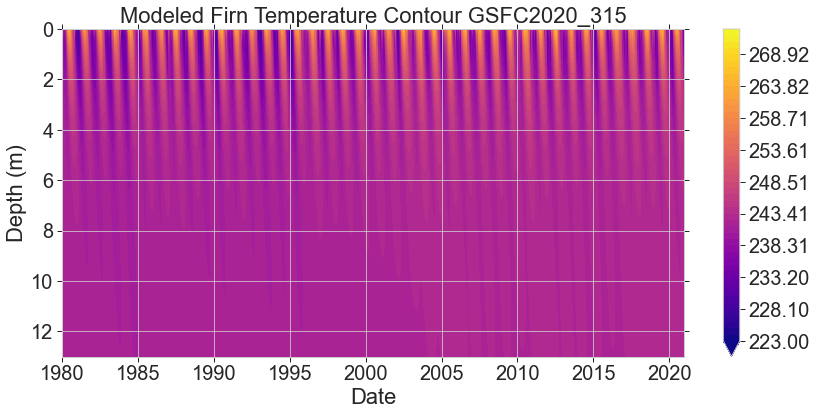

In [31]:
## Use FirnCover to plot temperature contour with colorbar
# Plot temperature with depth
fns = ['GSFC2020']
rvs = [315]
rd = {} #results dictionary
for physics in fns:
    for rv in rvs:
        print(physics)
        print(rv)
        ff = f'CFMoutputs/CFMresults_{lat_val}_{lon_val}_{physics}_{rv}_Tplus{t_adjust}/CFMresults.hdf5'
        open_fn = h5.File(ff,'r') # Open the CFM results file
        physics_rv = physics + '_' + str(rv)
        print(physics_rv)
        vars_list = list(open_fn.keys()) # Make a list of the variables stored in the file
        # The first row in each of the model outputs is the initial condition, so we don't want that (i.e. start by using the data in 2nd row)
        # The first column is the time step. So, we use index [1:,1:] on most of the variables to get just the data we want.
        rd[physics_rv] = {}
        rd[physics_rv]['model_time'] = open_fn['density'][1:,0]
        rd[physics_rv]['depth'] = open_fn['depth'][1:,1:] # Put the depth data into a numpy array
        rd[physics_rv]['density'] = open_fn['density'][1:,1:] # Put the density data into an array
        rd[physics_rv]['temperature'] = open_fn['temperature'][1:,1:]
        rd[physics_rv]['DIP'] = open_fn['DIP'][1:,1:]
        rd[physics_rv]['Dcon'] = open_fn['Dcon'][1:,1:]
        rd[physics_rv]['Datetime'] = pd.to_datetime([decyeartodatetime(iii) for iii in rd[physics_rv]['model_time']])
        open_fn.close() # Close the file

x_df = rd[physics_rv]['model_time']
y_df = rd[physics_rv]['depth']
z_df = rd[physics_rv]['temperature']

### the measurements are on an irregular grid because the depths of the thermistors were always changing during the observation period
### so to plot we need to interpolate the data onto a regularly spaced grid

grid_res = 0.1 #resolution of our interpolated grid, i.e we will interpolate onto a regular grid of 0.0, 0.1, 0.2, etc.
n_grid = np.arange(0,13+grid_res,grid_res) # n_grid is our regular grid
t_interp_mod =np.zeros((y_df.shape[0],len(n_grid))) # initialize a matrix that will hold the interpolated temperatures
time = x_df # time of observations

for kk in range(y_df.shape[0]): # loop through each day of observations and do the interpolation
    tif = sp.interpolate.interp1d(y_df[kk], z_df[kk], bounds_error=False) #scipy interpolation has you first create a function
    t_interp_mod[kk,:]= tif(n_grid) #apply the interpolation function
    
temps_interpolated_model = pd.DataFrame(t_interp_mod,index = pd.to_datetime([decyeartodatetime(dd) for dd in rd[physics_rv]['model_time']]),columns=n_grid) #put the interpolated temperatures into a data frame

### now contour plot
f1,a1=plt.subplots(figsize=(12,6))
levels = np.linspace(223, 273, 50)
cax1 = a1.contourf(time,n_grid,t_interp_mod.T, 50,extend = 'min', 
                        levels = levels, zorder=0, 
                        cmap='plasma')
a1.invert_yaxis()
a1.set_xlabel('Date')
a1.set_ylabel('Depth (m)')
a1.set_title(f'Modeled Firn Temperature Contour {physics_rv}')
a1.set_label('Firn temperature ($^o$C)')
cb1 = f1.colorbar(cax1)
figfilename = f'Contour_Modeled_Firn_Temp_GSFC_325.png'
f1.savefig(figfilename)

In [28]:
### Load data
# Summit_air_temp = pd.read_pickle(r'C:\Users\dswan1\Downloads\CFM\CommunityFirnModel\CFM_main\Summit_air_temp.pkl')
# Summit_rtd_depths = pd.read_pickle(r'C:\Users\dswan1\Downloads\CFM\CommunityFirnModel\CFM_main\Summit_rtd_depths.pkl') 
# Summit_sonic = pd.read_pickle(r'C:\Users\dswan1\Downloads\CFM\CommunityFirnModel\CFM_main\Summit_sonic_ranger.pkl')
# Summit_temps = pd.read_pickle(r'C:\Users\dswan1\Downloads\CFM\CommunityFirnModel\CFM_main\Summit_temperature_observed.pkl')

Summit_air_temp = pd.read_pickle(r'../Summit_air_temp.pkl')
Summit_rtd_depths = pd.read_pickle(r'../Summit_rtd_depths.pkl') 
Summit_sonic = pd.read_pickle(r'../Summit_sonic_ranger.pkl')
Summit_temps = pd.read_pickle(r'../Summit_temperature_observed.pkl')

### Flip the data frame order so that the data from shallowest thermistor (aka RTD) is the first column in the 
### data frame, and deepest is last
### and get rid of the data from the thermistors that were above surface at time of installation
Summit_rtd_depths=Summit_rtd_depths.iloc[:,::-1].drop(['rtd23','rtd22','rtd21','rtd20','rtd19','rtd18'],axis=1)
Summit_temps = Summit_temps.iloc[:,::-1].drop(['rtd23','rtd22','rtd21','rtd20','rtd19','rtd18'],axis=1)

### The sonic ranger time series has a bunch of missing data, so we fill that in with a linear interpolation
### which gives us a new data frame of the rtd depths without a bunch of nans
deltaseries = Summit_sonic.interpolate().delta
rtd_depths_filled = pd.DataFrame((-1*deltaseries.values[:,None]+Summit_rtd_depths.iloc[0].values[None,:]),columns = Summit_rtd_depths.columns, index = Summit_sonic.index)

/var/folders/5q/w3ggb85j2k5gcg7822zwtqmw0000gq/T/ipykernel_59261/4001925785.py:28: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  cb1 = f1.colorbar(cax1)


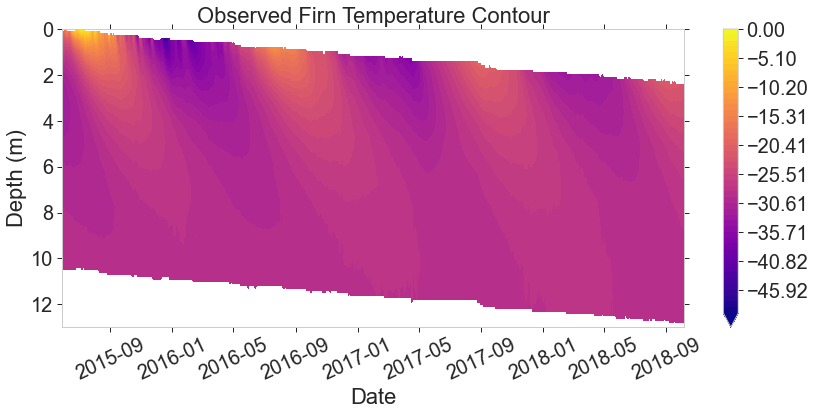

In [36]:
### the measurements are on an irregular grid because the depths of the thermistors were always changing during the observation period
### so to plot we need to interpolate the data onto a regularly spaced grid

grid_res = 0.1 #resolution of our interpolated grid, i.e we will interpolate onto a regular grid of 0.0, 0.1, 0.2, etc.
n_grid = np.arange(0,13+grid_res,grid_res) # n_grid is our regular grid
t_interp_data=np.zeros((rtd_depths_filled.shape[0],len(n_grid))) # initialize a matrix that will hold the interpolated temperatures
time = Summit_temps.index # time of observations

for kk in range(rtd_depths_filled.shape[0]): # loop through each day of observations and do the interpolation
    tif = sp.interpolate.interp1d(rtd_depths_filled.iloc[kk].values, Summit_temps.iloc[kk].values, bounds_error=False) #scipy interpolation has you first create a function
    t_interp_data[kk,:]= tif(n_grid) #apply the interpolation function
    
temps_interpolated_data = pd.DataFrame(t_interp_data,index = Summit_temps.index,columns=n_grid) #put the interpolated temperatures into a data frame

### now contour plot
f1,a1=plt.subplots(figsize=(12,6))
plt.grid(False)
levels = np.linspace(-50, 0, 50)
cax1 = a1.contourf(time,n_grid,t_interp_data.T, 50,extend = 'min', 
                        levels = levels, zorder=0, 
                        cmap='plasma')
a1.invert_yaxis()
a1.set_xlabel('Date')
a1.tick_params(axis='x', rotation=25)
a1.set_ylabel('Depth (m)')
a1.set_title(f'Observed Firn Temperature Contour')
a1.set_label('Firn temperature ($^o$C)')
cb1 = f1.colorbar(cax1)
figfilename = f'Contour_Observed_Firn_Temp_GSFC_{rvs}.png'
f1.savefig(figfilename)

/var/folders/5q/w3ggb85j2k5gcg7822zwtqmw0000gq/T/ipykernel_59261/3787581938.py:34: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  cb1 = f1.colorbar(cax1, ticks=cbar_ticks)


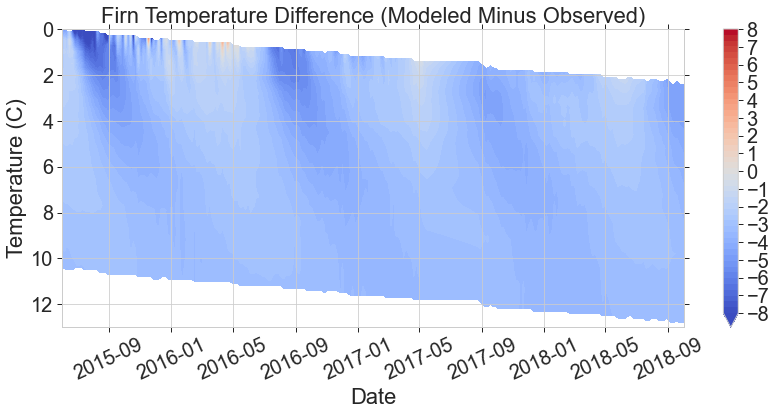

In [37]:
## Comparing the Modeled data to the Observed Data 

#hte model outputs
temps_interpolated_model = pd.DataFrame(t_interp_mod,index = pd.to_datetime([decyeartodatetime(dd) for dd in rd[physics_rv]['model_time']]),columns=n_grid) #put the interpolated temperatures into a data frame
temps_interpolated_model.index=temps_interpolated_model.index.round('D') # .index.round('D') = round to the nearest day because we are using decimal dates that are slightly off from each day

#hte data
temps_interpolated_data = pd.DataFrame(t_interp_data,index = Summit_temps.index,columns=n_grid) #put the interpolated temperatures into a data frame

#look at the model/data difference
overlaping_dates = temps_interpolated_data.index.intersection(temps_interpolated_model.index) # the dates that we have both model output and data
temps_data_subsampled = temps_interpolated_data.loc[overlaping_dates] #Select just the data from the overlaping dates
temps_model_subsampled = temps_interpolated_model.loc[overlaping_dates] #Select just the model outputs from the overlaping dates

temps_difference = ((temps_model_subsampled-273.15) - temps_data_subsampled) # We can then look at the difference between the model and data

#plot
f1,a1=plt.subplots(figsize=(12,6))
tmin = -8
tmax = 8
levels = np.linspace(tmin, tmax, 50)
cbar_ticks = np.linspace(tmin,tmax,tmax-tmin+1)
# cbar_ticks = np.linspace(-20,1,9)
# cbar_ticks = np.linspace(-10,10,5)
cax1 = a1.contourf(overlaping_dates,n_grid,temps_difference.T, 50,extend = 'min', 
                        levels = levels, zorder=0, 
                        cmap='coolwarm')
a1.invert_yaxis()
a1.set_xlabel('Date')
a1.tick_params(axis='x', rotation=25)
a1.set_ylabel('Temperature (C)')
a1.set_title(f'Firn Temperature Difference (Modeled Minus Observed)')
a1.set_label('Firn temperature')
cb1 = f1.colorbar(cax1, ticks=cbar_ticks)
figfilename = f'Contour_Firn_Temp_Diff_GSFC_{rvs}.png'
f1.savefig(figfilename)

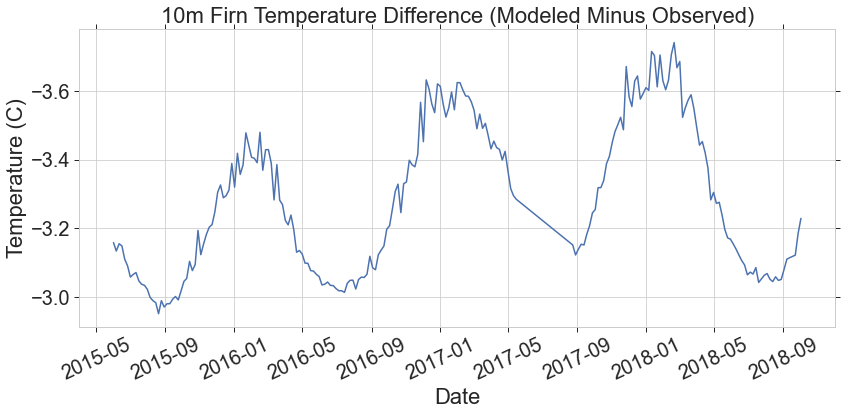

In [38]:

temps_difference_10m = ((temps_model_subsampled.iloc[:,100]-273.15) - temps_data_subsampled.iloc[:,100])

#plot
f1,a1=plt.subplots(figsize=(12,6))
a1.plot(overlaping_dates, temps_difference_10m)
a1.invert_yaxis()
a1.set_xlabel('Date')
a1.tick_params(axis='x', rotation=25)
a1.set_ylabel('Temperature (C)')
a1.set_title(f'10m Firn Temperature Difference (Modeled Minus Observed)')
a1.set_label('Firn temperature')
figfilename = f'10m_Firn_Temp_Diff_GSFC_{rvs}.png'
f1.savefig(figfilename)

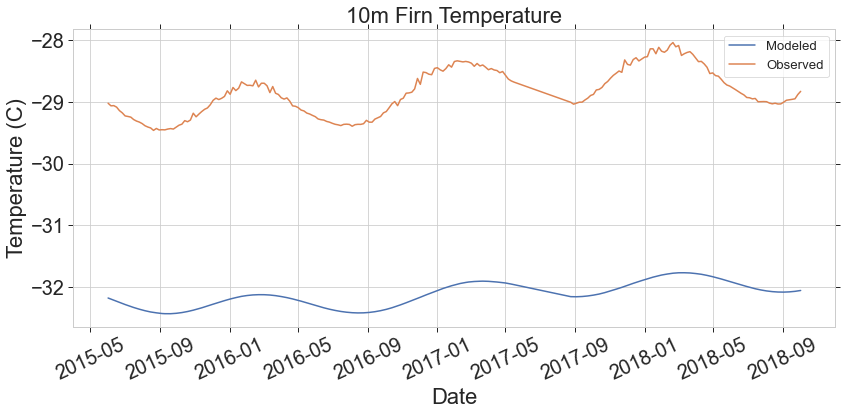

In [39]:
#10 m firn temperature plot
f1,a1=plt.subplots(figsize=(12,6))
a1.plot(overlaping_dates, temps_model_subsampled.iloc[:,100]-273.15, label = f'Modeled')
a1.plot(overlaping_dates, temps_data_subsampled.iloc[:,100], label = f'Observed')
a1.legend()
a1.set_xlabel('Date')
a1.tick_params(axis='x', rotation=25)
a1.set_ylabel('Temperature (C)')
a1.set_title(f'10m Firn Temperature')
a1.set_label('Firn temperature')
figfilename = f'10m_Firn_Temp_GSFC_{rvs}.png'
f1.savefig(figfilename)

+++++++++++
GSFC2020
315
CFMoutputs/CFMresults_72.5_-38.75_GSFC2020_315/CFMresults.hdf5
GSFC2020_315
+++++++++++
GSFC2020
315
CFMoutputs/CFMresults_72.5_-38.75_GSFC2020_315_Tplus1.5/CFMresults.hdf5
GSFC2020_315


Text(0.5, 1.0, 'GSFC2020_315')

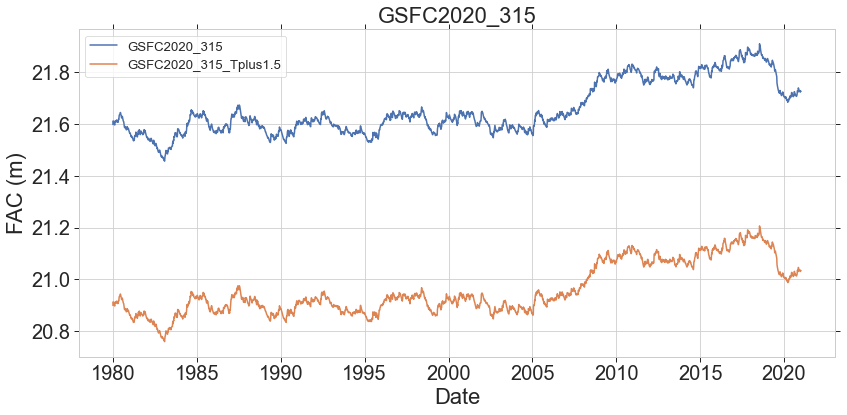

In [40]:
### Regular model output
fns = ['GSFC2020']
rvs = ['315']
rd = {} #results dictionary
for physics in fns:
    for rv in rvs:
        print('+++++++++++')
        print(physics)
        print(rv)
        ff = f'CFMoutputs/CFMresults_{lat_val}_{lon_val}_{physics}_{rv}/CFMresults.hdf5'
        print(ff)
        open_fn = h5.File(ff,'r') # Open the CFM results file
        physics_rv = physics + '_' + str(rv)
        print(physics_rv)
        print('+++++++++++')
        vars_list = list(open_fn.keys()) # Make a list of the variables stored in the file
        # The first row in each of the model outputs is the initial condition, so we don't want that (i.e. start by using the data in 2nd row)
        # The first column is the time step. So, we use index [1:,1:] on most of the variables to get just the data we want.
        rd[physics_rv] = {}
        rd[physics_rv]['model_time'] = open_fn['density'][1:,0]
        rd[physics_rv]['depth'] = open_fn['depth'][1:,1:] # Put the depth data into a numpy array
        rd[physics_rv]['density'] = open_fn['density'][1:,1:] # Put the density data into an array
        rd[physics_rv]['temperature'] = open_fn['temperature'][1:,1:]
        rd[physics_rv]['DIP'] = open_fn['DIP'][1:,1:]
        rd[physics_rv]['Dcon'] = open_fn['Dcon'][1:,1:]
        rd[physics_rv]['Datetime'] = pd.to_datetime([decyeartodatetime(iii) for iii in rd[physics_rv]['model_time']])
        open_fn.close() # Close the file

### Model output Plus t_adjust
rd2 = {} #results dictionary
for physics in fns:
    for rv in rvs:
        print('==========')
        print(physics)
        print(rv)
        ff2 = f'CFMoutputs/CFMresults_{lat_val}_{lon_val}_{physics}_{rv}_Tplus{t_adjust}/CFMresults.hdf5'
        print(ff2)
        open_fn2 = h5.File(ff2,'r') # Open the CFM results file
        physics_rv = physics + '_' + str(rv)
        print(physics_rv)
        print('==========')
        vars_list = list(open_fn2.keys()) # Make a list of the variables stored in the file
        # The first row in each of the model outputs is the initial condition, so we don't want that (i.e. start by using the data in 2nd row)
        # The first column is the time step. So, we use index [1:,1:] on most of the variables to get just the data we want.
        rd2[physics_rv] = {}
        rd2[physics_rv]['model_time'] = open_fn2['density'][1:,0]
        rd2[physics_rv]['depth'] = open_fn2['depth'][1:,1:] # Put the depth data into a numpy array
        rd2[physics_rv]['density'] = open_fn2['density'][1:,1:] # Put the density data into an array
        rd2[physics_rv]['temperature'] = open_fn2['temperature'][1:,1:]
        rd2[physics_rv]['DIP'] = open_fn2['DIP'][1:,1:]
        rd2[physics_rv]['Dcon'] = open_fn2['Dcon'][1:,1:]
        rd2[physics_rv]['Datetime'] = pd.to_datetime([decyeartodatetime(iii) for iii in rd2[physics_rv]['model_time']])
        open_fn.close() # Close the file
        
f1,a1=plt.subplots(figsize=(12,6))
a1.plot(rd[physics_rv]['Datetime'][:],rd[physics_rv]['DIP'][:,0],label=f'GSFC2020_315')
a1.plot(rd2[physics_rv]['Datetime'][:],rd2[physics_rv]['DIP'][:,0],label=f'GSFC2020_315_Tplus{t_adjust}')
a1.legend()
a1.set_xlabel('Date')
a1.set_ylabel('FAC (m)')
a1.set_title(f'GSFC2020_315')

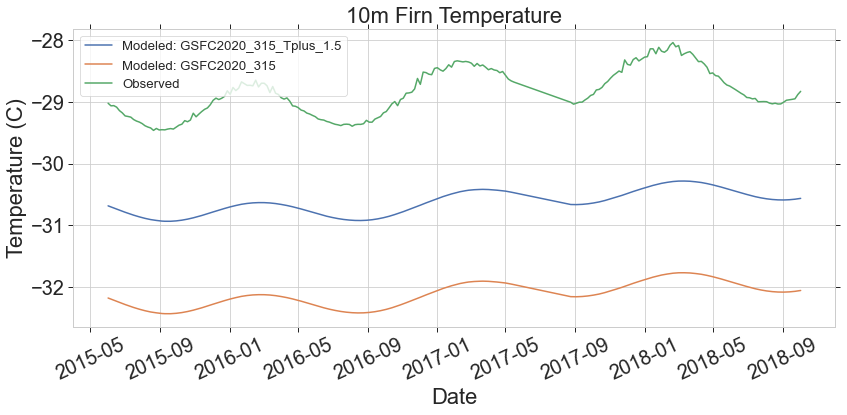

In [41]:
#Comparing the Modeled +1.5 firn temp to the Modeled firn temp

x_df = rd[physics_rv]['model_time']
y_df = rd[physics_rv]['depth']
z_df = rd[physics_rv]['temperature']

x_df_Tplus = rd2[physics_rv]['model_time']
y_df_Tplus = rd2[physics_rv]['depth']
z_df_Tplus = rd2[physics_rv]['temperature']

#Modeled outputs +1.5
grid_res = 0.1 #resolution of our interpolated grid, i.e we will interpolate onto a regular grid of 0.0, 0.1, 0.2, etc.
n_grid = np.arange(0,13+grid_res,grid_res) # n_grid is our regular grid

t_interp_mod_Tplus =np.zeros((y_df_Tplus.shape[0],len(n_grid))) # initialize a matrix that will hold the interpolated temperatures
t_interp_mod =np.zeros((y_df.shape[0],len(n_grid)))

for rr in range(y_df_Tplus.shape[0]): # loop through each day of observations and do the interpolation
    tif_Tplus = sp.interpolate.interp1d(y_df_Tplus[rr], z_df_Tplus[rr], bounds_error=False) #scipy interpolation has you first create a function
    t_interp_mod_Tplus[rr,:]= tif_Tplus(n_grid) #apply the interpolation function
    
for kk in range(y_df.shape[0]): # loop through each day of observations and do the interpolation
    tif = sp.interpolate.interp1d(y_df[kk], z_df[kk], bounds_error=False) #scipy interpolation has you first create a function
    t_interp_mod[kk,:]= tif(n_grid) #apply the interpolation function    
    
temps_interpolated_mod_Tplus = pd.DataFrame(t_interp_mod_Tplus,index = pd.to_datetime([decyeartodatetime(dd) for dd in rd2[physics_rv]['model_time']]),columns=n_grid) #put the interpolated temperatures into a data frame
temps_interpolated_mod_Tplus.index=temps_interpolated_mod_Tplus.index.round('D') # .index.round('D') = round to the nearest day because we are using decimal dates that are slightly off from each day

#Modeled outputs
temps_interpolated_mod = pd.DataFrame(t_interp_mod,index = pd.to_datetime([decyeartodatetime(dd) for dd in rd[physics_rv]['model_time']]),columns=n_grid) #put the interpolated temperatures into a data frame
temps_interpolated_mod.index=temps_interpolated_mod.index.round('D') # .index.round('D') = round to the nearest day because we are using decimal dates that are slightly off from each day

#hte data
temps_interpolated_data = pd.DataFrame(t_interp_data,index = Summit_temps.index,columns=n_grid) #put the interpolated temperatures into a data frame

#look at the model/data difference
overlaping_dates = temps_interpolated_data.index.intersection(temps_interpolated_mod.index) # the dates that we have both model output and data
temps_data_subsampled = temps_interpolated_data.loc[overlaping_dates] #Select just the data from the overlaping dates
temps_model_subsampled_Tplus = temps_interpolated_mod_Tplus.loc[overlaping_dates] #Select just the model outputs from the overlaping dates
temps_model_subsampled_ = temps_interpolated_mod.loc[overlaping_dates]

f1,a1=plt.subplots(figsize=(12,6))
a1.plot(overlaping_dates, temps_model_subsampled_Tplus.iloc[:,100]-273.15, label = f'Modeled: GSFC2020_315_Tplus_1.5')
a1.plot(overlaping_dates, temps_model_subsampled.iloc[:,100]-273.15, label = f'Modeled: GSFC2020_315')
a1.plot(overlaping_dates, temps_data_subsampled.iloc[:,100], label = f'Observed')
a1.legend()
a1.set_xlabel('Date')
a1.tick_params(axis='x', rotation=25)
a1.set_ylabel('Temperature (C)')
a1.set_title(f'10m Firn Temperature')
figfilename = f'10m_Firn_Temp_GSFC_{rvs}_ModeledTplus_{t_adjust}.png'
f1.savefig(figfilename)

In [115]:
# z_df_Tplus[:,0] - z_df[:,0]

In [93]:
# t_interp_mod_Tplus - t_interp_mod

In [94]:
# temps_model_subsampled_Tplus - temps_model_subsampled

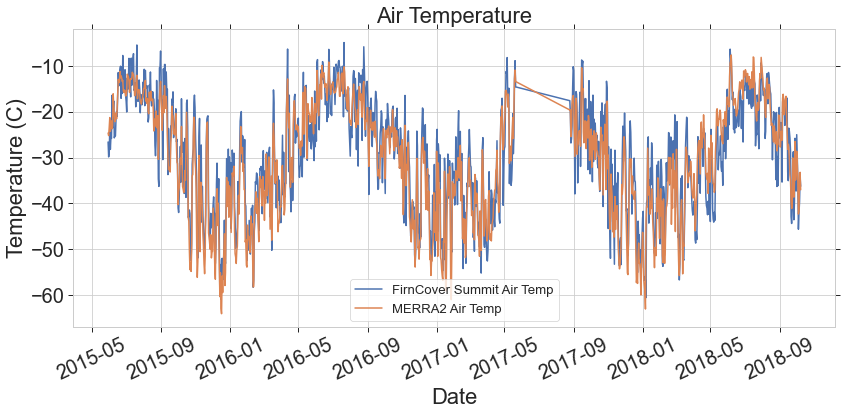

In [112]:
### Compare FirnCover air temp to MERRA2 data

overlap_dates = df_daily.index.intersection(Summit_air_temp.index)
df_daily_subsampled = df_daily.loc[overlap_dates] #Select just the data from the overlaping dates
Summit_air_subsampled = Summit_air_temp.loc[overlap_dates]

f1,a1=plt.subplots(figsize=(12,6))
a1.plot(overlap_dates, Summit_air_subsampled['air_temp_C'], label=f'FirnCover Summit Air Temp')
a1.plot(overlap_dates, df_daily_subsampled['TS']-273.15, label=f'MERRA2 Air Temp')
a1.tick_params(axis='x', rotation=25)
a1.legend()
a1.set_xlabel('Date')
a1.set_ylabel('Temperature (C)')
a1.set_title(f'Air Temperature')
figfilename = f'FirnCover_MERRA2_Air_Temp.png'
f1.savefig(figfilename)